Starting matched filter search...

Search complete!


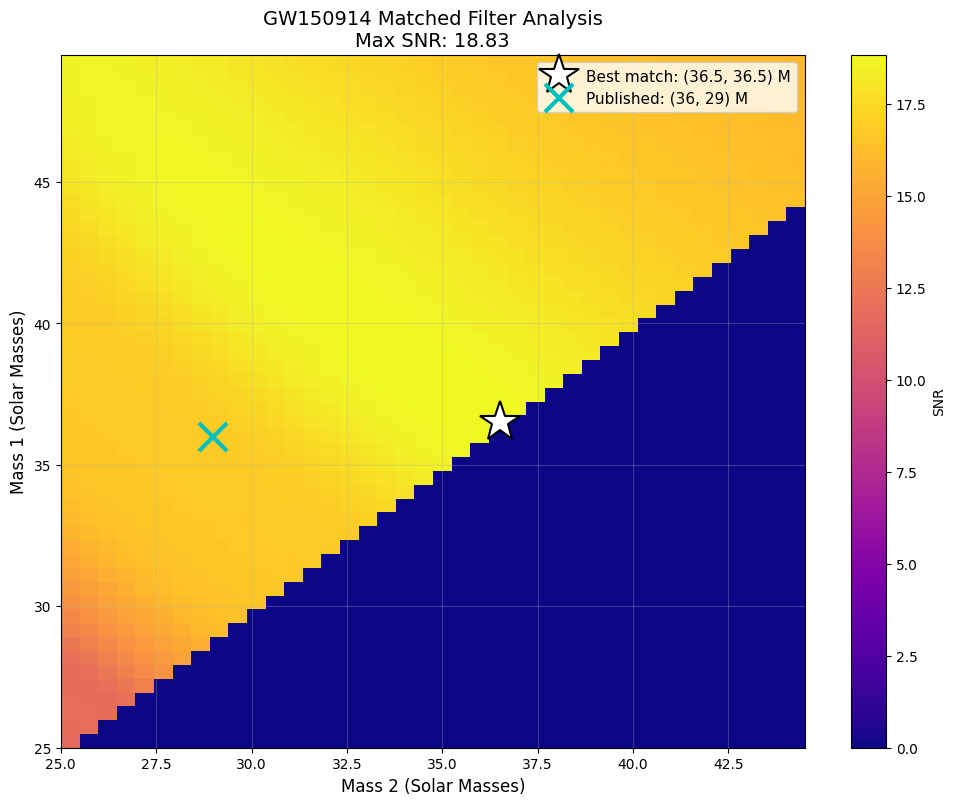


Best matching masses: M1=36.5 M, M2=36.5 M
Maximum SNR: 18.83
Published values: M1=36 M, M2=29 M
Difference: ΔM1=0.5, ΔM2=7.5


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter import highpass_fir, lowpass_fir, matched_filter
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
from pycbc.waveform import get_fd_waveform

# Getting data
merger = Merger("GW150914")
strain_data = merger.strain("H1")

# Apply filters - only highpass to remove low-frequency noise
strain_data = highpass_fir(strain_data, 15, 8)

# Calculate PSD
psd = interpolate(welch(strain_data), 1.0 / strain_data.duration)
strain_data = strain_data.to_frequencyseries()

mass1_range = np.arange(25, 50, 0.5)  
mass2_range = np.arange(25, 45, 0.5)  
approximant = "IMRPhenomD"

# Initialize arrays
snr_values = np.zeros((len(mass1_range), len(mass2_range)))
global_snr_max = 0
best_mass = (0, 0)

# Compute matched filter for each mass combination
print("Starting matched filter search...")
for i, m1 in enumerate(mass1_range):
    for j, m2 in enumerate(mass2_range):
        if m1 >= m2:  # Only compute for m1 >= m2
            hp, hc = get_fd_waveform(
                approximant=approximant,
                mass1=m1,
                mass2=m2,
                f_lower=15.0,  
                delta_f=1.0/strain_data.duration
            )
            
            hp.resize(len(strain_data))
            
            # Compute SNR
            snr = matched_filter(hp, strain_data, psd=psd, low_frequency_cutoff=15.0)  # CHANGED
            snr = snr[len(snr) // 4: len(snr) * 3 // 4]   # just slicing or zooming to remove edge effects
            max_snr = abs(snr).max()
            snr_values[i, j] = max_snr
            
            if max_snr > global_snr_max:
                global_snr_max = max_snr
                best_mass = (m1, m2)
                

print(f"\nSearch complete!")

# Plotting
plt.figure(figsize=(12, 9))

plt.imshow(snr_values, 
           extent=[mass2_range[0], mass2_range[-1], 
                   mass1_range[0], mass1_range[-1]],
           cmap='plasma', origin='lower', aspect='auto')

# Mark best match and published value
plt.plot(best_mass[1], best_mass[0], 'w*', markersize=30, 
         label=f'Best match: ({best_mass[0]:.1f}, {best_mass[1]:.1f}) M', 
         markeredgecolor='black', markeredgewidth=1.5)
plt.plot(29, 36, 'cx', markersize=20, markeredgewidth=3,
         label='Published: (36, 29) M')  # ADDED: Reference marker

plt.colorbar(label='SNR')
plt.xlabel('Mass 2 (Solar Masses)', fontsize=12)
plt.ylabel('Mass 1 (Solar Masses)', fontsize=12)
plt.title(f'GW150914 Matched Filter Analysis\nMax SNR: {global_snr_max:.2f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

#plt.savefig('gw_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest matching masses: M1={best_mass[0]:.1f} M, M2={best_mass[1]:.1f} M")
print(f"Maximum SNR: {global_snr_max:.2f}")
print(f"Published values: M1=36 M, M2=29 M")
print(f"Difference: ΔM1={abs(best_mass[0]-36):.1f}, ΔM2={abs(best_mass[1]-29):.1f}")
